# `AA Workshop 13` - Time Series Analysis

In this notebook, we provide a short introduction to time series analysis in Python.

----

## Introduction

**Definition:**

A univariate time series is a sequence of measurements of the same variable collected over time.  Most often, the measurements are made at regular time intervals.

One difference from standard linear regression is that the data are not necessarily independent and not necessarily identically distributed. One defining characteristic of time series is that this is a list of observations where the ordering matters. Ordering is very important because there is dependency and changing the order could change the meaning of the data.

**Basic Objectives of the Analysis**

The fundamental objective usually is to determine a model that describes the pattern of the time series. Use cases for such a model are:

- to describe the important features of the time series pattern.
- to explain how the past affects the future or how two time series can “interact”.
- to forecast future values of the series.
- to possibly serve as a control standard for a variable that measures the quality of product in some manufacturing situations.

**Types of Models**

There are two basic types of “time domain” models.

1. Models that relate the present value of a series to past values and past prediction errors - these are called **ARIMA** models (for Autoregressive Integrated Moving Average).

2. Ordinary regression models that use time indices as x-variables. These can be helpful for an initial description of the data and form the basis of several simple forecasting methods.

**Some important questions to consider when first looking at a time series are:**

- Is there a trend, meaning that, on average, the measurements tend to increase (or decrease) over time?
- Is there seasonality, meaning that there is a regularly repeating pattern of highs and lows related to calendar time such as seasons, quarters, months, days of the week, and so on?
- Are their outliers? In a regression, outliers are far away from your line. With time series data, your outliers are far away from your other data.
- Is there a long-run cycle or period unrelated to seasonality factors?
- Is there constant variance over time, or is the variance non-constant?
- Are there any abrupt changes to either the level of the series or the variance?

----

# Handling Time Series Data in Pandas

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10
import warnings
warnings.filterwarnings("ignore")

Let's load an exemplary time series dataset and first look at some initial rows and data types of the columns:

In [2]:
data = pd.read_csv('../data/AirPassengers.csv')
print(data.head(), '\n Data Types: \n',data.dtypes )

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121 
 Data Types: 
 Month          object
#Passengers     int64
dtype: object


The data contains a particular month and number of passengers travelling in that month. But this is still not read as a TS object as the data types are ‘object’ and ‘int’. In order to read the data as a time series, we have to pass special arguments to the read_csv command:

In [3]:
data = pd.read_csv('../data/AirPassengers.csv', index_col='Month', parse_dates=['Month'])
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Let’s understand the arguments one by one:

**parse_dates:** This specifies the column which contains the date-time information. As we say above, the column name is ‘Month’.

**index_col:** A key idea behind using Pandas for TS data is that the index has to be the variable depicting date-time information. So this argument tells pandas to use the ‘Month’ column as index.

----

# Checking for Stationarity

A TS is said to be stationary if its statistical properties such as mean and variance remain constant over time. But why is this important? Most of the TS models work on the assumption that the TS is stationary. Intuitively, we can set that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future. Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

Stationarity is defined using very strict criteria. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

- constant mean
- constant variance
- an autocovariance that does not depend on time.

First, simply plot the data and analyze it visually.

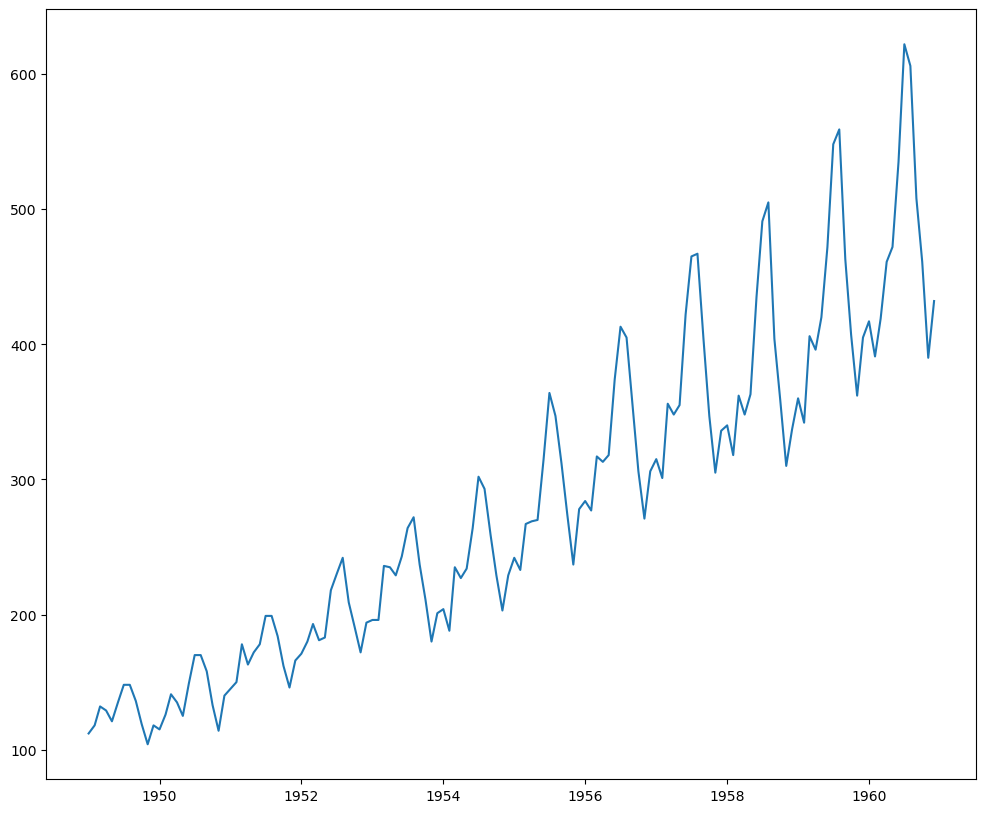

In [4]:
plt.plot(data)
plt.show()

It is clearly evident that there is an overall increasing trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences. So, more formally, we can check for stationarity using the following:

- **Plotting Rolling Statistics:** We can plot the moving average or moving variance and see if it varies with time. By moving average/variance we mean that at any instant `t`, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

- **Dickey-Fuller Test:** This is one of the statistical tests for checking stationarity. Here, the null hypothesis is that the TS is non-stationary. The test results consist of a `Test Statistic` and some `Critical Values` for different confidence levels. If the `Test Statistic` is less than the `Critical Value`, we can reject the null hypothesis and say that the series is stationary.

These concepts might not sound very intuitive at this point. If you are interested in some theoretical background, you can refer to `Introduction to Time Series and Forecasting` by Brockwel and Davis. The book is a bit stats-heavy, but if you have the skill to read-between-lines, you can understand the concepts and tangentially touch the statistics.

Back to checking for stationarity, we’ll be using the rolling statistics plots along with the Dickey-Fuller test results. Below, we define a function which takes a TS as input and generates both for us. Please note that we’ve plotted standard deviation instead of variance to keep the unit similar to the mean.

In [5]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    # determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # plot rolling statistics
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:\n')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

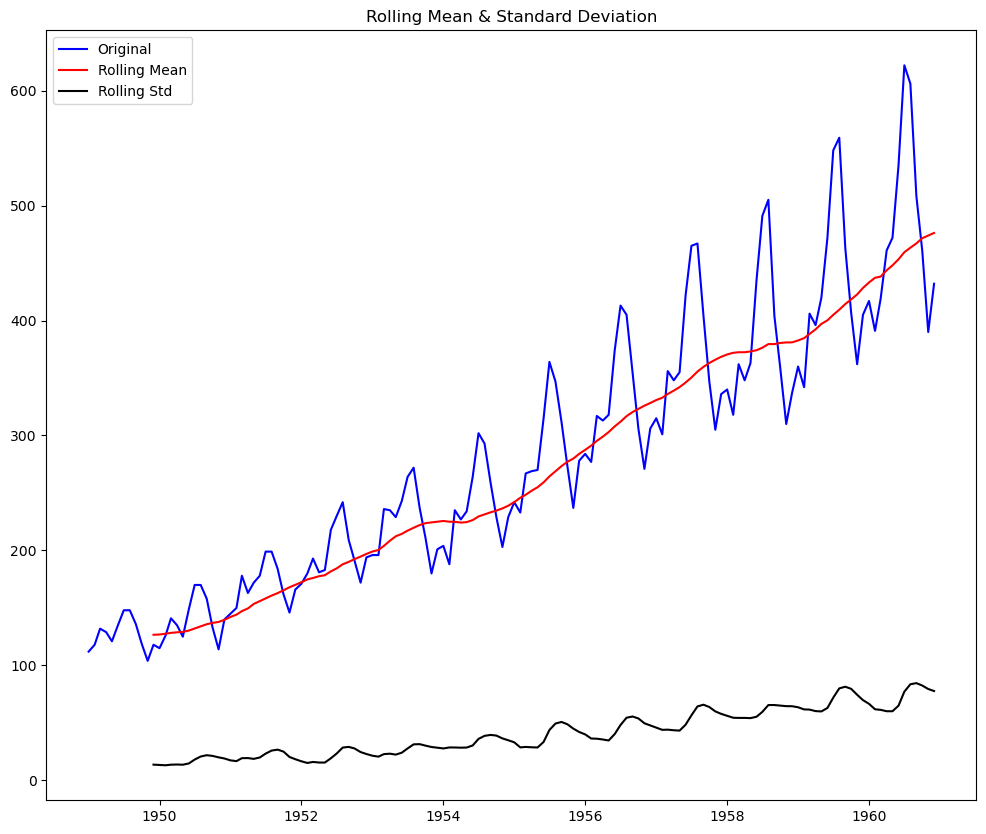

Results of Dickey-Fuller Test:

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [6]:
# check for stationarity for our time series dataset
test_stationarity(data['#Passengers'])

Though the variation in standard deviation is rather small, the mean is clearly increasing with time - this is not a stationary series. Also, the test statistic is way higher than the critical values - we clearly fail to reject the null hypothesis of non-stationarity.

----

# Making a Time Series Stationary

Though stationarity is assumed in many TS models, almost no practical time series data are stationary. So statisticians have figured out ways to make series stationary, which we’ll discuss now. Actually, it is almost impossible to make a series perfectly stationary, but we try to take it as close as possible.

Lets first understand what is making a TS non-stationary. There are 2 major reasons:
1. **Trend** – varying mean over time. In our example dataset we saw that on average, the number of passengers was growing over time.
2. **Seasonality** – variations at specific time-frames. E.g. people might have a tendency to buy cars in a particular month because of bonus payments.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then, statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

Note: We’ll be discussing a number of methods. Some might work well in this case and others might not. But the idea is to get a hang of all the methods and not focus on just the problem at hand.

Let’s start by working on the trend part.

### Estimating & Eliminating Trend

One of the first tricks to reduce trend can be **transformation**. For example, in this case we can clearly see that there is a significant positive trend. So, we could apply transformation which penalize higher values more than smaller values. These include taking a `log, square root, cube root`, etc. Let's try a log-transform here for simplicity:

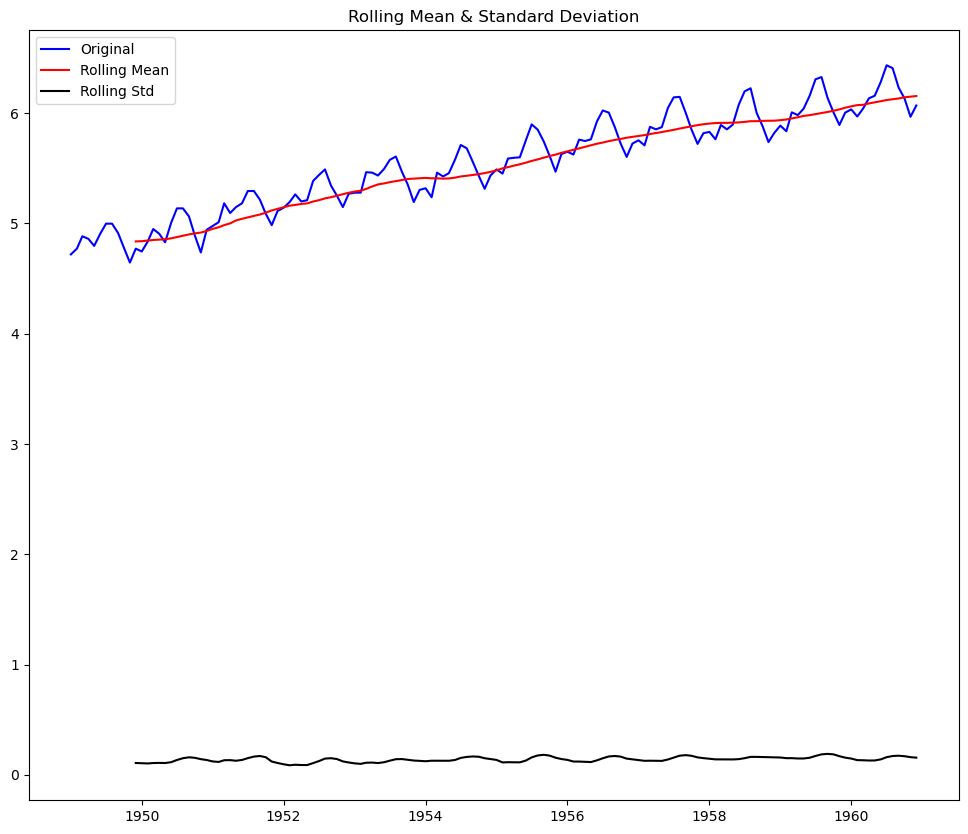

Results of Dickey-Fuller Test:

Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [7]:
# implement and evaluate log-transformation
ts_log = np.log(data['#Passengers'])
test_stationarity(ts_log)

Alternatively, we could use some techniques to estimate or model the trend and then remove it from the series. There can be many ways of doing it and some of the most commonly used ones are:

- Aggregation – taking averages for a time period like monthly/weekly averages
- Smoothing – taking rolling averages
- Polynomial Fitting – fit a regression model

We will discuss smoothing here, but you should try other techniques as well which might work out better for other problems. Smoothing refers to taking rolling estimates, i.e. considering the past few instances. There can be various ways but we will discuss two of those here.

**Moving average**: In this approach, we take an average of `k` consecutive values depending on the frequency of the time series. Here we can take the average over the past 1 year, i.e. the past 12 values. Pandas has specific functions defined for determining rolling statistics.

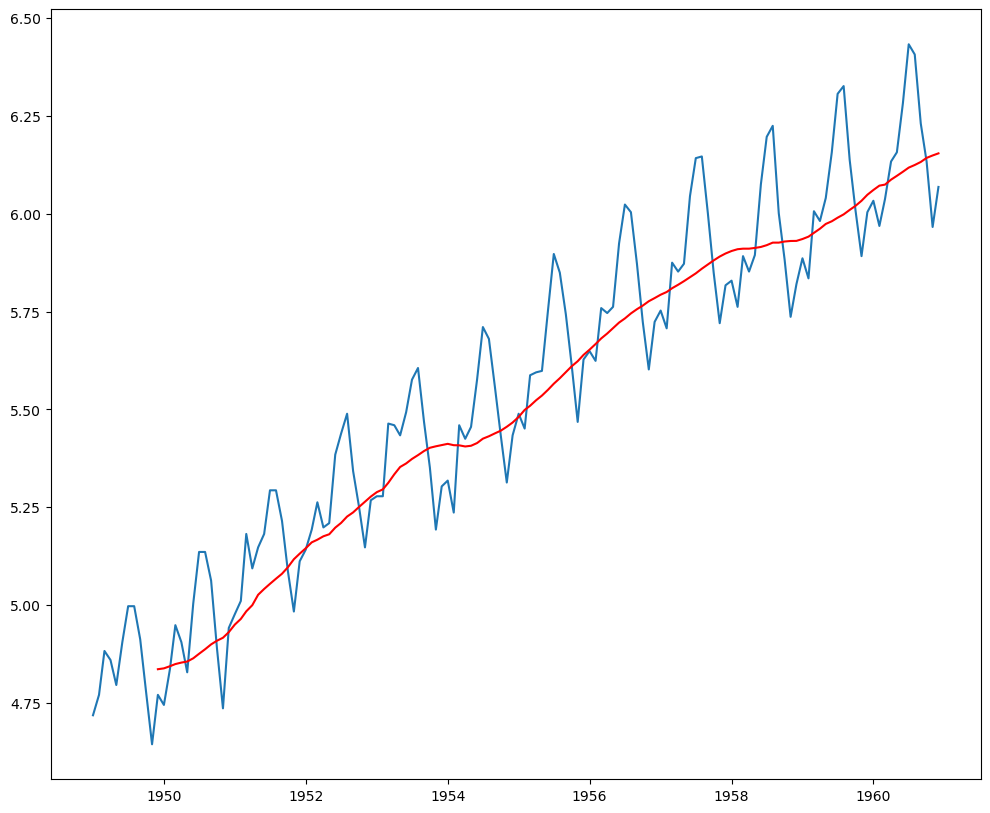

In [8]:
# implement moving average
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
plt.show()

The red line shows the rolling average. Lets subtract this from the original series. Note that since we are taking an average of the last 12 values, the rolling mean is not defined for the first 11 values. This can be observed as:

In [9]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

Notice the first 11 are NaN. Lets drop these NaN values and check the plots to check for stationarity.

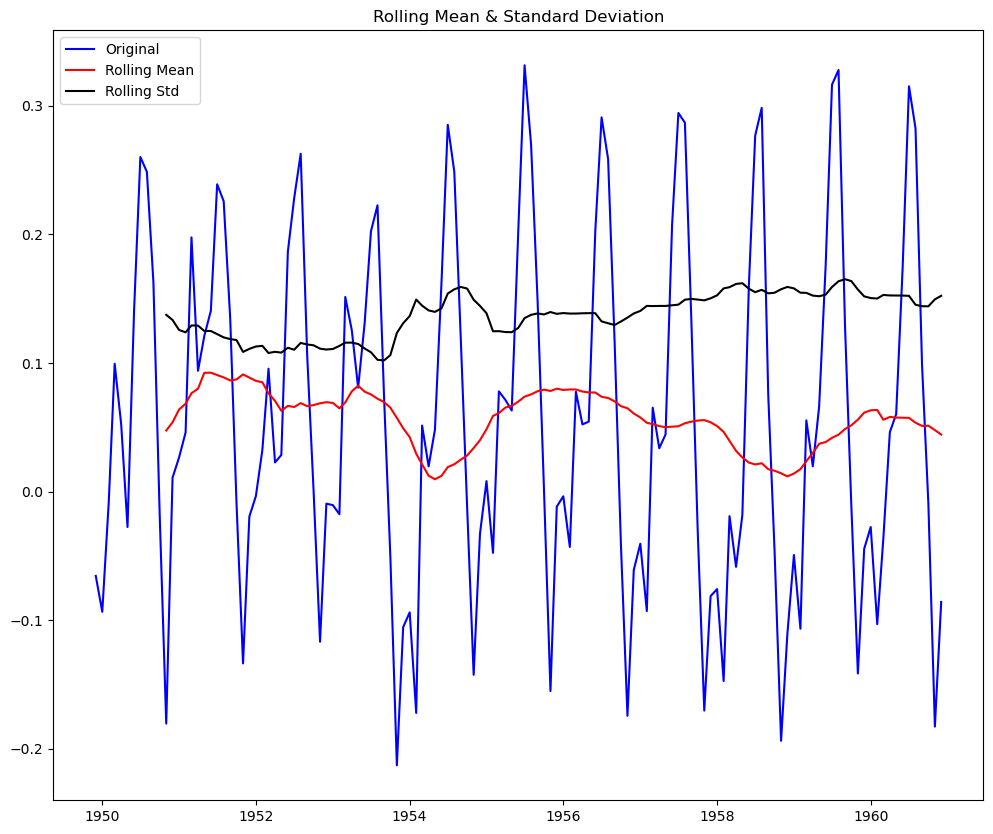

Results of Dickey-Fuller Test:

Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [10]:
# check for stationarity
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

This looks like a much better series. The rolling values appear to be varying slightly but there is no specific trend. Also, the test statistic is smaller than the 5% critical values, so we can say with 95% confidence that this is a stationary series.

However, a drawback in this particular approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. So we take a ‘weighted moving average’ where more recent values are given a higher weight. There can be many technique for assigning weights. A popular one is **exponentially weighted moving average** where weights are assigned to all the previous values with a decay factor. This can be implemented in Pandas as:

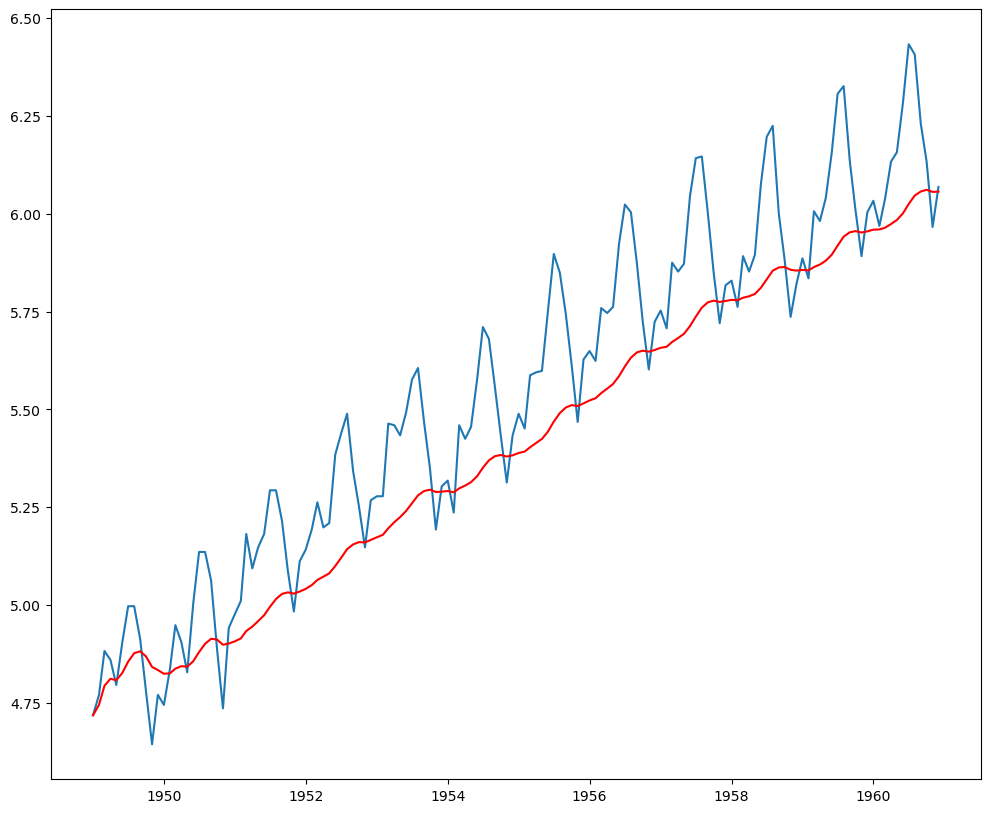

In [11]:
expwighted_avg=ts_log.ewm(halflife = 12).mean() # provides exponential weighted functions
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
plt.show()

Note that here the parameter ‘halflife’ is used to define the amount of exponential decay. This is just an assumption here and would depend largely on the business domain. Other parameters like span and center of mass can also be used to define decay (check out the documentation for details). Now, let’s remove this from the series and check for stationarity:

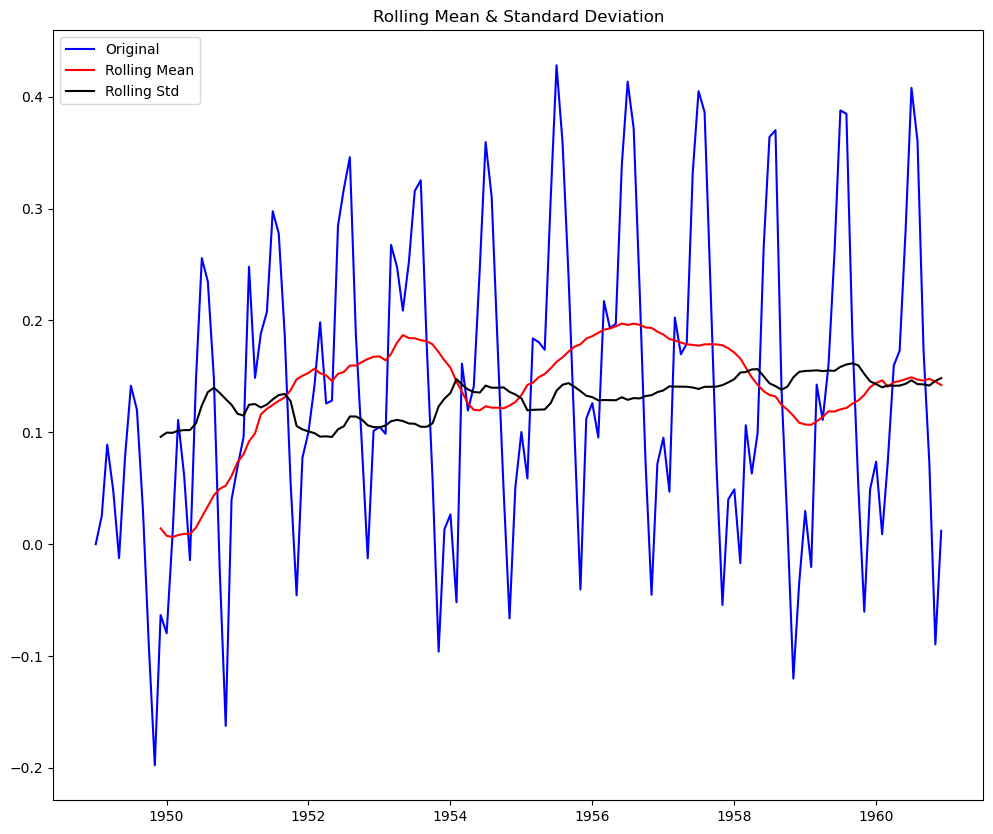

Results of Dickey-Fuller Test:

Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [12]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

This TS has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the 1% critical value, which is better than the previous case. Note that in this case there will be no missing values as all values from starting are given weights. So it’ll work even with no previous values.

### Estimating & Eliminating Trend & Seasonality

The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Let's discuss two ways of removing trend and seasonality:

1. Differencing – taking the differece with a particular time lag
2. Decomposition – modeling both trend and seasonality and removing them from the model.

**Differencing**

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well to improve stationarity. First order differencing can be done in Pandas as:

In [13]:
ts_log.shift(periods=1)

Month
1949-01-01         NaN
1949-02-01    4.718499
1949-03-01    4.770685
1949-04-01    4.882802
1949-05-01    4.859812
                ...   
1960-08-01    6.432940
1960-09-01    6.406880
1960-10-01    6.230481
1960-11-01    6.133398
1960-12-01    5.966147
Name: #Passengers, Length: 144, dtype: float64

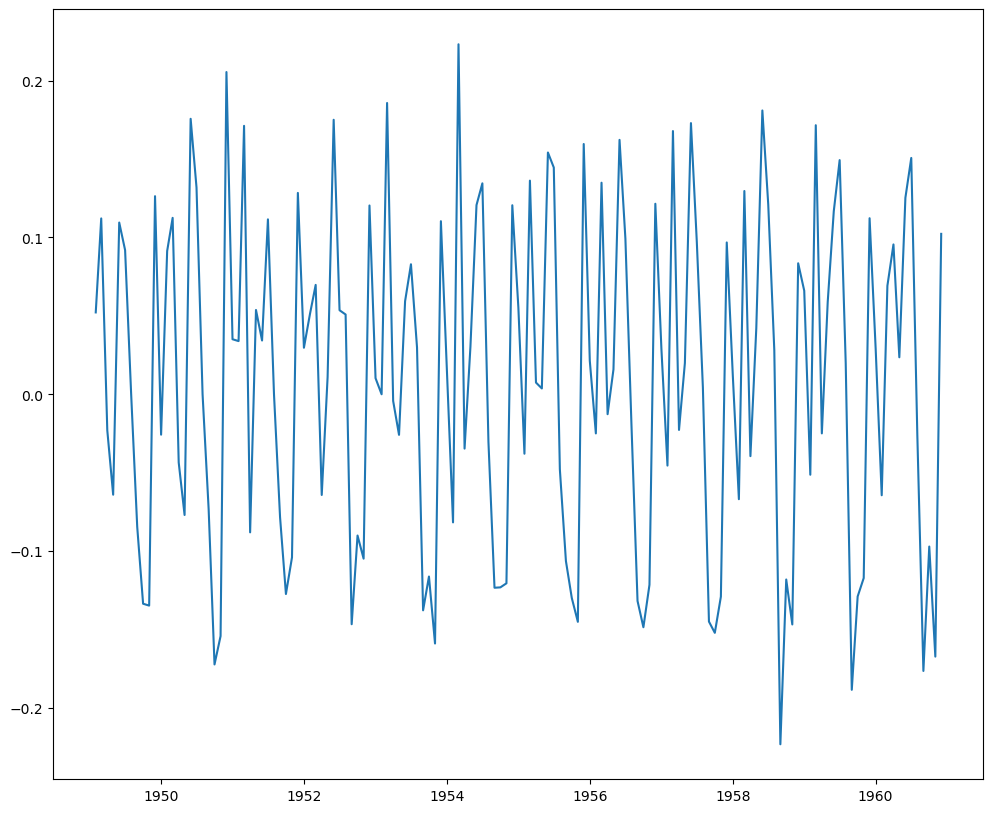

In [14]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.show()

This appears to have reduced trend considerably. Lets verify using our plots and test statistic:

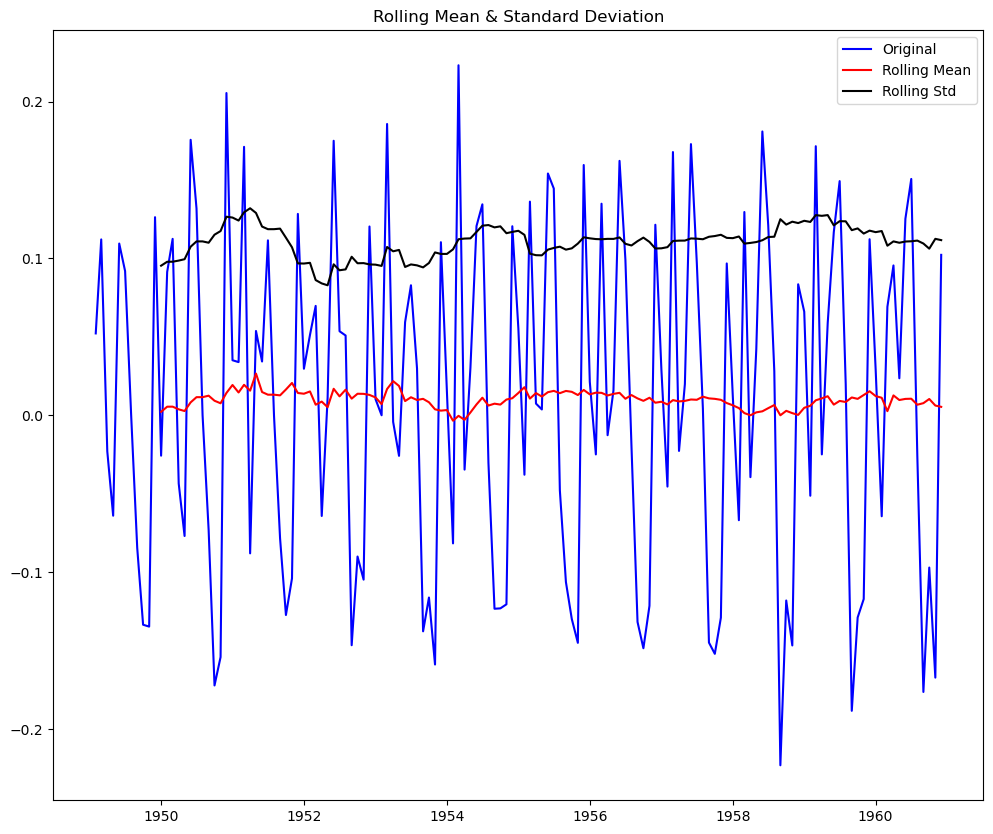

Results of Dickey-Fuller Test:

Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [15]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

We can see that the mean and std. deviation have small variations with time. Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence. We can also take second or third order differences, which might get even better results in certain applications. I leave it to you to try them out.

**Decomposing**

In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned. Let's skip the statistics and come to the results:

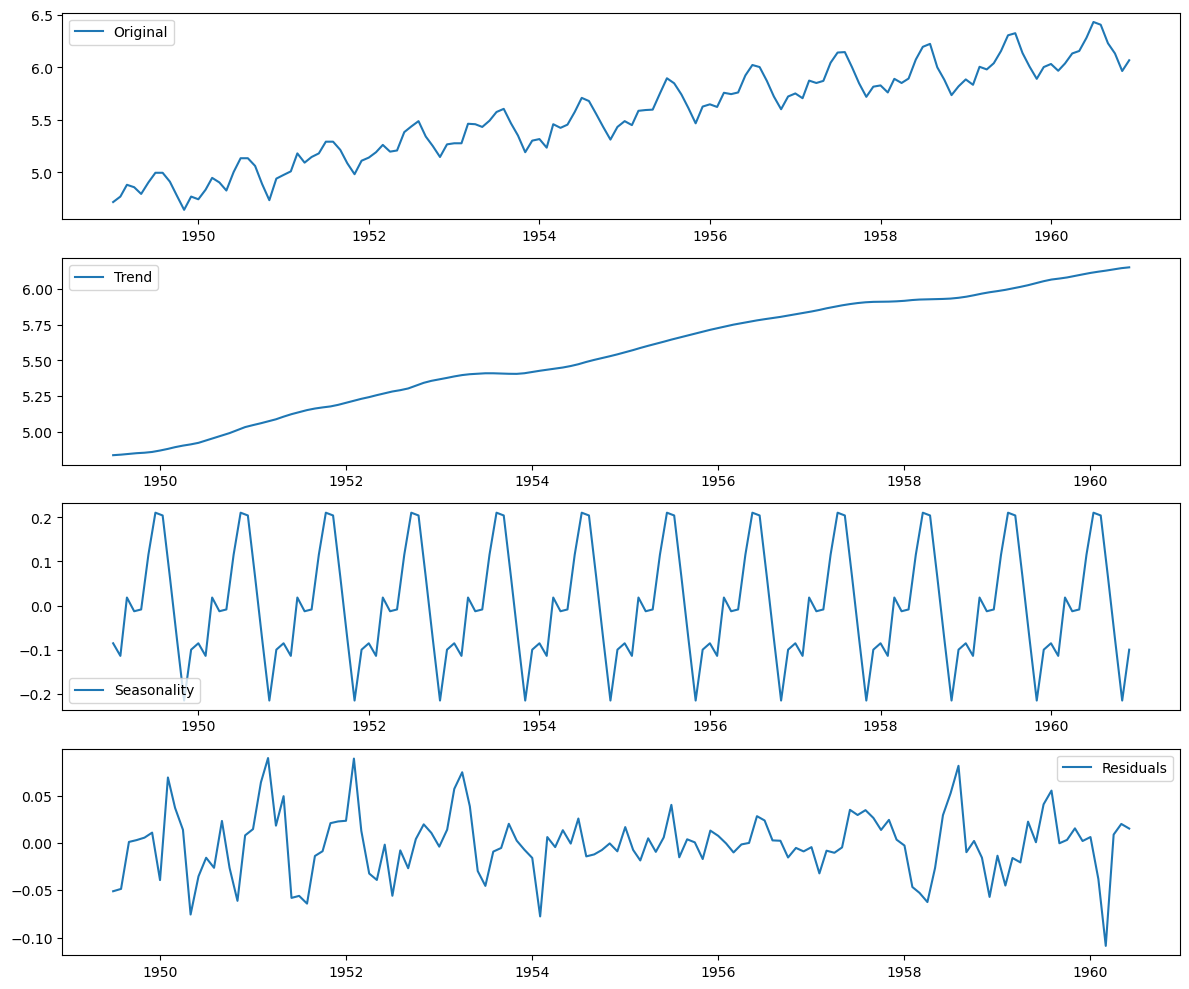

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log) # seasonal decomposition using moving averages

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Here we can see that the trend & seasonality are separated out from the data and we can model the residuals. Let's check stationarity of the residuals:

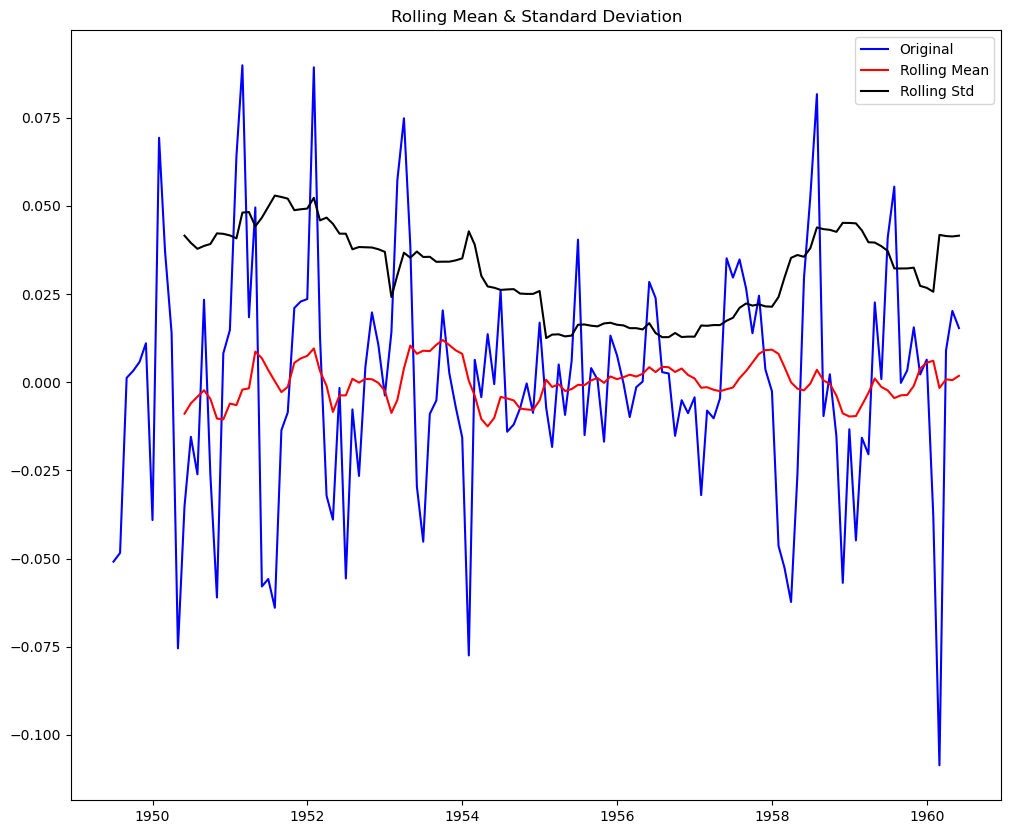

Results of Dickey-Fuller Test:

Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [17]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary. You can try advanced decomposition techniques as well, which can generate better results. However, you should note that converting the residuals into original values for future data is not very intuitive in this case.

----

# Forecasting a Time Series

We saw different techniques and all of them worked reasonably well for making the TS stationary. Let's construct a model on the TS after differencing as it is a very popular technique. Also, it's relatively easy to add trend and seasonality back into predicted residuals in this case. Having performed the trend and seasonality estimation techniques, there can be two situations:

- A strictly stationary series with no dependence among the values. This is the easy case where we can model the residuals as white noise. However, this is very rare.
- A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.

Let me give you a **brief introduction to ARIMA**. ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

- Number of AR (Auto-Regressive) terms (p): AR terms are just lags of the dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

- Number of Differences (d): These are the number of nonseasonal differences. In our case, we took the first order difference. So either we can pass our already differenced series and set d=0 or pass the original series and set d=1. Both will generate the same results.

- Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in the prediction equation. For instance, if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at the ith instant and the actual value.


An important concern here is how to determine the values of ‘p’ and ‘q’. We use two plots to determine these numbers. Let's discuss them first.

1. **Autocorrelation Function (ACF):** This is a measure of the correlation between the TS with a lagged version of itself. For instance at lag 5, ACF would compare the series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).

2. **Partial Autocorrelation Function (PACF):** This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. E.g. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

The ACF and PACF plots for the TS after differencing can be plotted as:

In [18]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

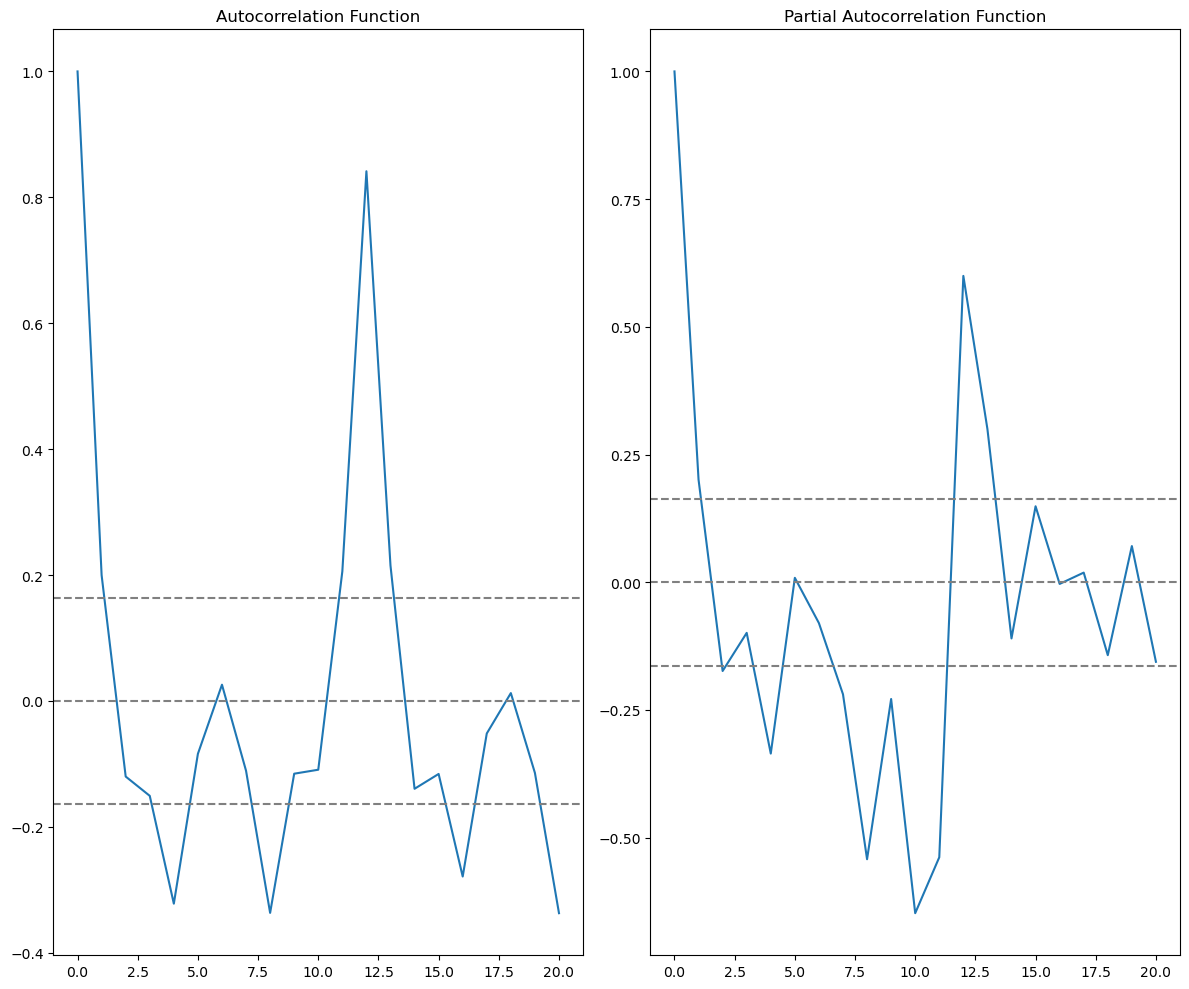

In [19]:
# plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. The following rules of thumb apply:
- If ACF cuts off sharply after lag q, then MA(q) model may be appropriate
- If PACF cuts off sharply after lag p, then AR(p) model may be appropriate
- If they decay gradually, a mixed model may be appropriate

Based on the above plots, let's construct 3 different ARIMA models considering individual as well as combined effects. We will also print the residual sum of squares (RSS) for each.

We need to load the ARIMA model first:

In [20]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

The p,d,q values can be specified using the order argument of ARIMA, which takes a tuple (p,d,q). Let's model the 3 cases:

**AR Model**

C:\Users\micha\anaconda3\envs\AA_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


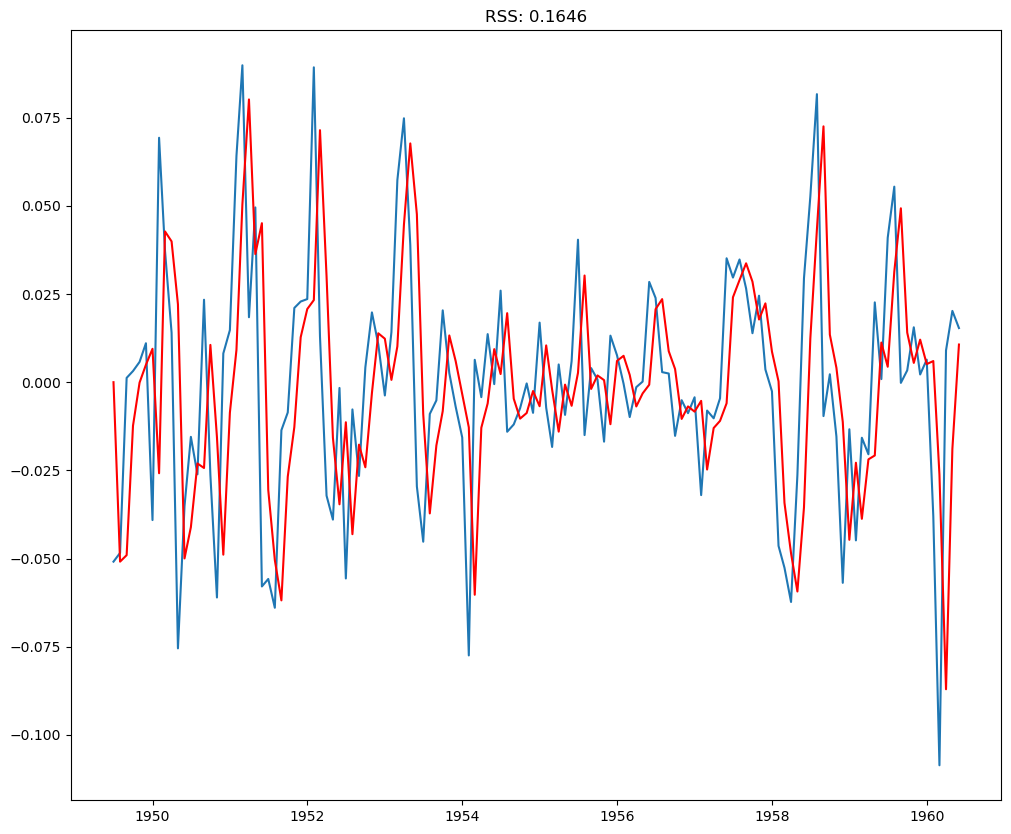

In [21]:
model = ARIMA(ts_log_decompose, order=(2, 1, 0), freq='MS') # MS: month start  
results_AR = model.fit()  
plt.plot(ts_log_decompose)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_decompose)**2))
plt.show()

**MA Model**

C:\Users\micha\anaconda3\envs\AA_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


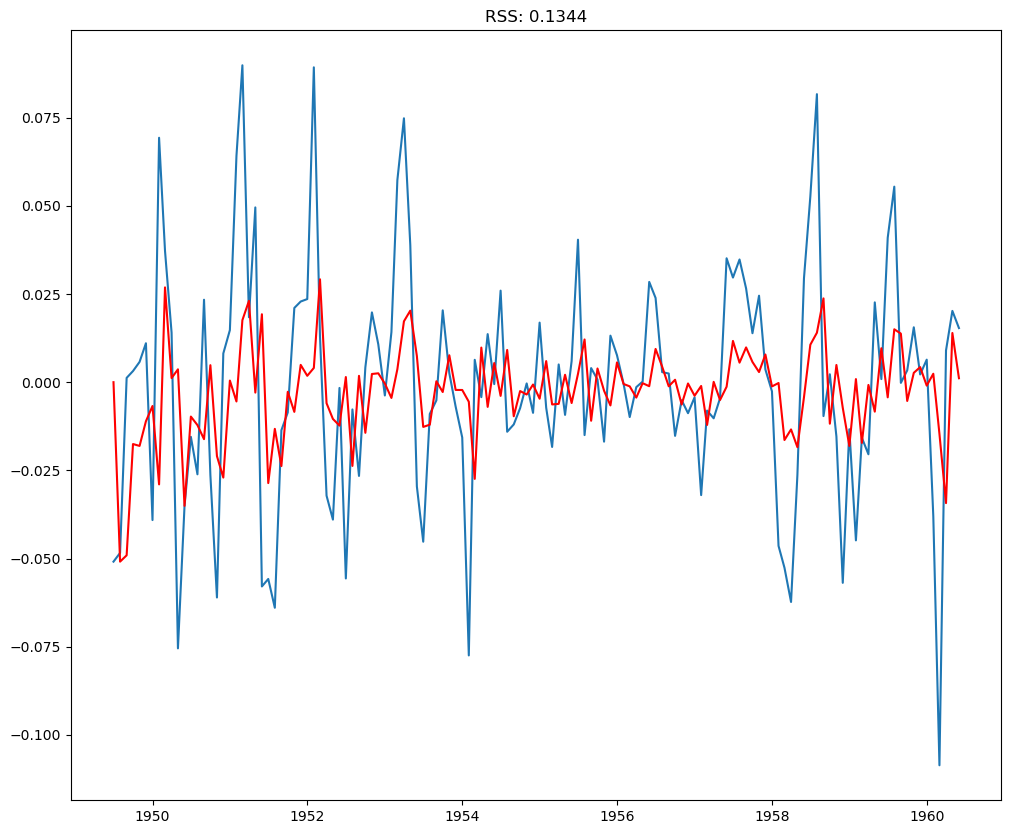

In [22]:
model = ARIMA(ts_log_decompose, order=(0, 1, 2), freq='MS')  
results_MA = model.fit()  
plt.plot(ts_log_decompose)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_decompose)**2))
plt.show()

**Combined Model**

C:\Users\micha\anaconda3\envs\AA_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


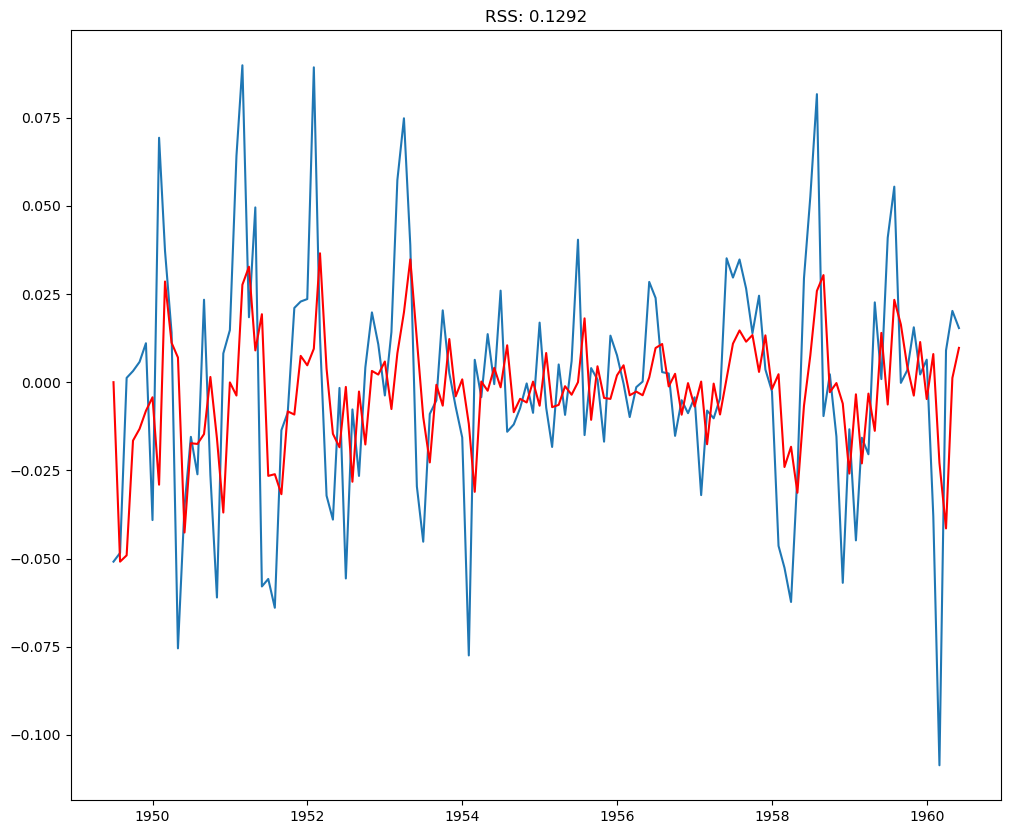

In [23]:
model = ARIMA(ts_log_decompose, order=(2, 1, 2), freq='MS')  
results_ARIMA = model.fit()  
plt.plot(ts_log_decompose)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_decompose)**2))
plt.show()

Here we can see that the combined model performs best. Now, we are left with 1 last step, i.e. taking these values back to the original scale.

**Taking it back to original scale**

Since the combined model gave the best result, let's scale it back to the original values and see how well it performs there. The first step is to store the predicted results as a separate series and observe it.

In [24]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-07-01    0.000000
1949-08-01   -0.050884
1949-09-01   -0.049099
1949-10-01   -0.016565
1949-11-01   -0.013227
dtype: float64

Notice that these start from ‘1949-07-01’ and not the first month. Why? This is because we decomposed (the trend component seems to register after six month) and the first element doesn’t have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively. An easy way to do it is to first determine the cumulative sum at index. The cumulative sum can be found as:

In [25]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-07-01    0.000000
1949-08-01   -0.050884
1949-09-01   -0.099983
1949-10-01   -0.116548
1949-11-01   -0.129776
dtype: float64

Next we have to add them back to the trend and seasonality component. For this lets create a series with all values as base number and add the differences to it. This can be done as:

In [26]:
predictions_ARIMA_log = pd.Series(0, index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log = predictions_ARIMA_log.add(decomposition.trend, fill_value=0)
predictions_ARIMA_log = predictions_ARIMA_log.add(decomposition.seasonal, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01   -0.085815
1949-02-01   -0.114413
1949-03-01    0.018113
1949-04-01   -0.013046
1949-05-01   -0.008966
dtype: float64

Here the first element is the base number itself and from thereon the values cumulatively added. Last step is to take the exponent and compare with the original series.

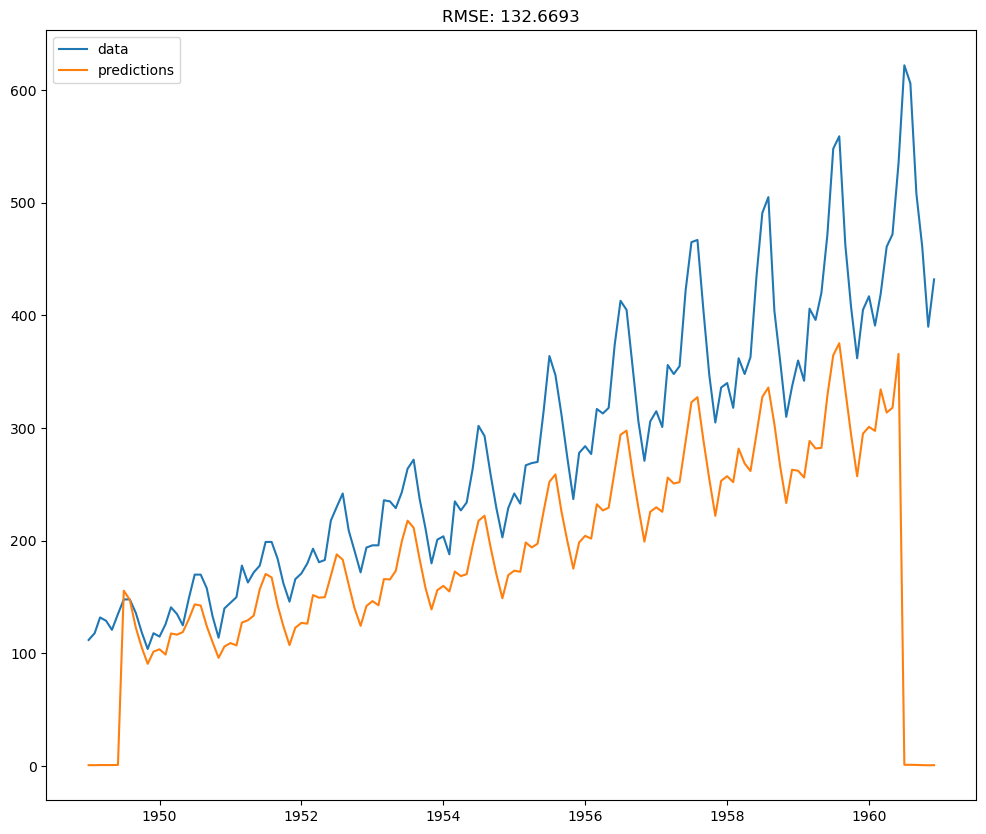

In [27]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data, label="data")
plt.plot(predictions_ARIMA, label="predictions")
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data['#Passengers'])**2)/len(data)))
plt.legend()
plt.show()

Note: We can clearly see the artifact of where the decomposed time series trend and seasonality component were not extrapolated.
This can be circumvented by using more elaborate decomposition techniques.

----